In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import os

%matplotlib notebook

# Step 1. Read / Merge and Normalize Data:

First read the data, then merge and normalize the data with the following steps:

1. Normalize Open / High / Low / Close / Adjusted Close and retain information by: calculating returns (returns of adjusted close) / returns in day (returns in the day, in terms of open and close) / range ratio in the day (high - low / open)

2. Normalize Volume = log( log( volume + 1) + 1). In some cases, if the volume of that day is 0, we just do not remove this data. In this case, the new volume is still 0.

3. Normalize 12-Month London Interbank Offered Rate (LIBOR), based on U.S. Dollar (USD12MD156N): divide by 100 to get the real value (percentage)

4. Normalize Trade Weighted U.S. Dollar Index: Major Currencies, Goods; Index Mar 1973=100, Not Seasonally Adjusted (DTWEXM): DTWEXM (new) = (DTWEXM - 100) / 100: 100 is like the benchmark index

5. Normalize Moody's Seasoned Aaa Corporate Bond Yield, Percent, Not Seasonally Adjusted (DAAA): divide by 100 to get the real value (percentage)

6. Normalize VIXCLS (CBOE Volatility Index: VIX; Index, Not Seasonally Adjusted): divide by 100 to get the real value (percentage)

7. Normalize The Fama-French Five Factor Model data (Mkt-RF, SMB, HML, RMW and CMA): divide by 100 to get the real value (percentage)

The `y` that we want to predict: The stock `GE` is what we are interested in.

I want to predict `GE` mainly because as shown in the last section, the average returns of `GE` are closest to 0, and therefore an accuracy evaluation of 50% is relatively a good criteria of our model.

In [3]:
y_index = "GE_ret"

In [4]:
os.listdir("data")

['data.csv', 'raw', 'test.csv', 'train.csv']

In [5]:
df_stocks = pd.read_csv("data/raw/sample-stocks.csv")
df_fred = pd.read_csv("data/raw/sample-fred.csv")
df_ff5 = pd.read_csv("data/raw/sample-ff5.csv")

df_fred.index = pd.to_datetime(df_fred["DATE"])
df_ff5.index = pd.to_datetime(df_ff5["Date"])

In [6]:
symbols = list(pd.unique(df_stocks["Symbol"]))
freds = [col for col in df_fred.columns if col != "DATE"]
ffs = [col for col in df_ff5.columns if col != "Date"]

symbols, freds, ffs

(['^GSPC', 'XOM', 'AAPL', 'INTC', 'GS', 'GE', 'AXP', 'WMT', 'PG'],
 ['USD12MD156N', 'DTWEXM', 'DAAA', 'VIXCLS'],
 ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'])

In [7]:
df = pd.DataFrame()

for sym, df_sym in df_stocks.groupby("Symbol"):
    
    df_sym.index = pd.to_datetime(df_sym["Date"])

    df_sym_new = pd.DataFrame(index = df_sym.index)
    df_sym_new["{}_ret".format(sym)] = df_sym["Adj Close"].diff(1) / df_sym["Adj Close"].shift(1)
    df_sym_new["{}_loglogVol".format(sym)] = np.log( np.log( df_sym["Volume"] + 1 ) + 1 )
    df_sym_new["{}_retInday".format(sym)] = (df_sym["Close"] - df_sym["Open"])/df_sym["Open"]
    df_sym_new["{}_rangeRatio".format(sym)] = (df_sym["High"] - df_sym["Low"])/df_sym["Open"]
    df = pd.concat([df, df_sym_new], axis=1)

df = pd.concat([df, df_fred[freds], df_ff5[ffs]], axis=1)

df["USD12MD156N"] /= 100
df["DTWEXM"] = (df["DTWEXM"] - 100) / 100
df["DAAA"] /= 100
df["VIXCLS"] /= 100

df[ffs] /= 100

retNext = df[y_index].shift(-1)
retNext = retNext.rename(y_index + "Next")

df = pd.concat([retNext, df], axis=1)

df = df.fillna(method="ffill")

df = df.dropna()

df.head()

,GE_retNext,AAPL_ret,AAPL_loglogVol,AAPL_retInday,AAPL_rangeRatio,AXP_ret,AXP_loglogVol,AXP_retInday,AXP_rangeRatio,GE_ret,...,USD12MD156N,DTWEXM,DAAA,VIXCLS,Mkt-RF,SMB,HML,RMW,CMA,RF
2000-01-04,-0.001736,-0.084310,2.979007,-0.053118,0.087182,-0.037759,2.842653,-0.025754,0.043461,-0.039999,...,0.066000,-0.047467,0.0769,0.2701,-0.0406,0.0033,0.0221,0.0033,0.0146,0.00021
2000-01-05,0.013369,0.014634,3.000041,0.002410,0.072892,-0.021863,2.831602,-0.021595,0.039036,-0.001736,...,0.065713,-0.047077,0.0778,0.2641,-0.0009,0.0031,0.0014,0.0036,0.0101,0.00021
2000-01-06,0.038721,-0.086538,2.999374,-0.104829,0.113074,0.020373,2.845640,0.032646,0.047251,0.013369,...,0.065800,-0.043024,0.0772,0.2573,-0.0073,-0.0013,0.0138,0.0053,0.0120,0.00021
2000-01-07,-0.000413,0.047368,2.973591,0.031088,0.056995,0.014559,2.810005,0.011194,0.033167,0.038721,...,0.065838,-0.042774,0.0769,0.2172,0.0321,-0.0097,-0.0124,-0.0079,-0.0095,0.00021
2000-01-10,0.001653,-0.017588,2.978276,-0.041667,0.073529,0.013940,2.797649,0.010212,0.030637,-0.000413,...,0.065738,-0.039870,0.0772,0.2171,0.0176,0.0053,-0.0151,-0.0187,-0.0007,0.00021


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GE_retNext,5216.0,0.000024,0.019681,-0.127891,-0.008348,0.000000,0.008315,0.197031
AAPL_ret,5216.0,0.001241,0.025185,-0.518692,-0.010238,0.000895,0.012787,0.139049
AAPL_loglogVol,5216.0,2.956341,0.041619,2.839164,2.926541,2.958888,2.987428,3.106440
AAPL_retInday,5216.0,0.000291,0.020627,-0.120047,-0.009652,0.000345,0.009973,0.131278
AAPL_rangeRatio,5216.0,0.028578,0.020120,0.004138,0.014920,0.022869,0.035688,0.232439
AXP_ret,5216.0,0.000574,0.021955,-0.175949,-0.007880,0.000464,0.009464,0.206486
AXP_loglogVol,5216.0,2.804234,0.035264,2.683617,2.779875,2.800213,2.824955,2.961092
AXP_retInday,5216.0,0.000412,0.018746,-0.147013,-0.007429,0.000366,0.008153,0.155182
AXP_rangeRatio,5216.0,0.023932,0.020256,0.002506,0.011795,0.017550,0.028877,0.256423
GE_ret,5216.0,0.000014,0.019689,-0.127891,-0.008360,0.000000,0.008315,0.197031


The standard deviation of all the data are of the same scale. The data are successfully normalized!

In [9]:
df.to_csv("data/data.csv")

In [10]:
split_num = int(df.shape[0] * 0.8)
df_train = df[:split_num]
df_test = df[split_num:]

<IPython.core.display.Javascript object>


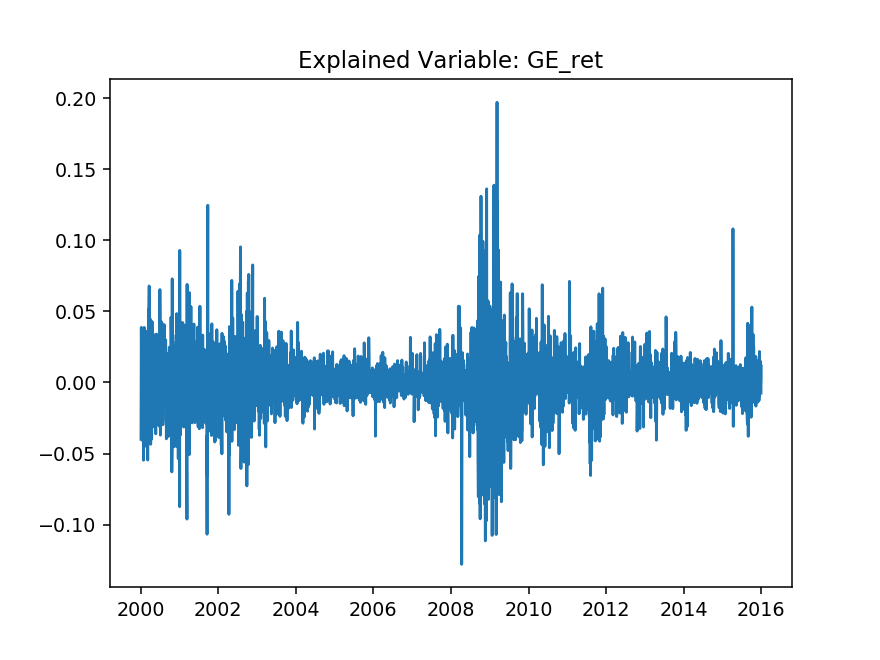

In [19]:
plt.figure()
plt.title("Explained Variable: " + y_index)
plt.plot(df_train[y_index])
plt.show()
plt.savefig("data/figs/fig1.png", dpi=600)

In [10]:
df_train.to_csv("data/train.csv", index=False, header=False)
df_test.to_csv("data/test.csv", index=False, header=False)